# PartB: Regression Problem

In [11]:
#IMPORT
from data import readData
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
sess = tf.Session()

## 0. Read Data

In [12]:
data = readData()
data = data / np.array((340, 120, 5, 5, 5, 10, 1, 1))

# Train Test split

In [13]:
# prepare data
# random
np.random.seed(231535622)

num_patterns = data.shape[0]
num_train_patterns = int(0.7*num_patterns)
total_indices = np.arange(num_patterns)

np.random.shuffle(total_indices)
train_indices = total_indices[:int(0.7*num_patterns)]
test_indices = total_indices[int(0.7*num_patterns):]

# 1. Build 4-layer feed forward neural network

### Mathematical Model
```
n: number of features,
b: batch size
x: R bxn
y: R bx1

h: number of hidden neurons

hidden1: R bxh = relu(x w1 + b1*)
    w1 (weight of hidden neurons): R nxh
    b1*: R bxh = 1* b1
    b1 (bias of hidden neurons): R 1xh
    1* (vector R bx1)

hidden2: R bxh = relu(hidden1 w2 + b2*)
    w2 (weight of hidden neurons): R nxh
    b2*: R bxh = 1* b2
    b2 (bias of hidden neurons): R 1xh
    1* (vector R bx1)

yp (output): R bx1 = linear(hidden2 w3 + b3*)
    w3 (weight of output neuron): R hx1
    b3*: R bx1 = 1* b3
    b3 (bias of output neurons): R 1x1
    1* (vector R bx1)

""" We can omit 1* in tensorflow
```

### Build Graph

In [14]:
# fixed params
n = 7 # number of features
b = 8 # batch size
h = 50 # number of hidden layer neurons
regularization_decay = 1e-3
# random
seed1 = 10
seed2 = 20
np.random.seed(seed1)
tf.random.set_random_seed(seed2)


# 4-layer 
# placeholders
x_shape = (None, n) # patterns are row vectors.
y_shape = (None, 1) # predicted values are a cell in a column vector.
x = tf.placeholder(dtype = tf.float32, shape = x_shape, name = "x")
y = tf.placeholder(dtype = tf.float32, shape = y_shape, name = "y")
drop_rate = tf.placeholder(dtype = tf.float32, shape = (), name = "drop_rate")

# weight, biases
w1_shape = (n, h)
b1_shape = (1, h)
w1 = tf.Variable(tf.random.truncated_normal(shape = w1_shape, stddev=1.0 / np.sqrt(n), dtype=tf.float32), name='w1') # taken from start_project1b
b1 = tf.Variable(tf.random.normal(shape = b1_shape, dtype = tf.float32), name = "b1") # take arbitrary

w2_shape = (h, h)
b2_shape = (1, h)
w2 = tf.Variable(tf.random.truncated_normal(shape = w2_shape, stddev=1.0 / np.sqrt(h), dtype=tf.float32), name = 'w2')
b2 = tf.Variable(tf.random.normal(shape = b2_shape, dtype = tf.float32), name = "b2")

w3_shape = (h, 1)
b3_shape = (1, 1)
w3 = tf.Variable(tf.random.truncated_normal(shape = w3_shape, stddev = 1.0 / np.sqrt(h), dtype = tf.float32), name = "w3")
b3 = tf.Variable(tf.random.normal(shape = b3_shape, dtype = tf.float32), name = "b3")

hidden1 = tf.nn.relu(tf.nn.dropout(tf.linalg.matmul(x, w1) + b1, rate = drop_rate), name = "hidden1")
hidden2 = tf.nn.relu(tf.nn.dropout(tf.linalg.matmul(hidden1, w2) + b2, rate = drop_rate), name = "hidden2")
yp = tf.identity(tf.linalg.matmul(hidden2, w3) + b3, name = "yp")
#yp = tf.math.sigmoid(tf.linalg.matmul(hidden, w2) + b2, name = "yp")

# loss + L2 regularization
#loss = tf.reduce_mean(tf.math.abs(yp - y))
loss = tf.reduce_mean(tf.math.log(tf.math.cosh(yp - y)))
#loss = tf.reduce_mean(tf.math.square(yp - y))

regularization_loss = tf.reduce_sum(tf.math.square(w1)) + tf.reduce_sum(tf.math.square(w2))
total_loss = loss + regularization_decay * regularization_loss

### Train without dropout

In [15]:
# Get data
x_np = data[:, :-1]
y_np = data[:, -1:]
print(x_np.shape)
print(y_np.shape)

x_train = x_np[train_indices]
y_train = y_np[train_indices]
x_test = x_np[test_indices]
y_test = y_np[test_indices]

(400, 7)
(400, 1)


In [16]:
# hyperparams
learning_rate = 1e-3
epochs = 10000
dropout = 0.0

# train op
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(total_loss)
sess = tf.Session()

# start train
listtrain_loss = []
listtest_loss = []

sess.run(tf.global_variables_initializer())

train_loss = sess.run(loss, feed_dict = {x: x_train, y:y_train, drop_rate: dropout})
test_loss = sess.run(loss, feed_dict = {x: x_test, y:y_test, drop_rate: dropout})
print("epoch 0, train loss {}, test loss {}".format(train_loss, test_loss))

for i in range(1, epochs+1, 1):
    for minibatch in range(0, num_train_patterns, b):
        sess.run(train_op, feed_dict = {
            x: x_train[minibatch:minibatch+b, :],
            y: y_train[minibatch:minibatch+b, :],
            drop_rate: dropout
        })
    # each epoch, reshuffle the trainset and record
    _indices = np.arange(num_train_patterns)
    np.random.shuffle(_indices)
    x_train = x_train[_indices]
    y_train = y_train[_indices]
    
    train_loss = sess.run(loss, feed_dict = {x: x_train, y:y_train, drop_rate: 0})
    test_loss = sess.run(loss, feed_dict = {x: x_test, y:y_test, drop_rate: 0})
    if (i % 100 == 0):
        print("epoch {}, train loss {}, test loss {}".format(i, train_loss, test_loss))
    listtrain_loss.append(train_loss)
    listtest_loss.append(test_loss)

epoch 0, train loss 2.5090484619140625, test loss 2.5116307735443115
epoch 100, train loss 0.003061913186684251, test loss 0.002955207135528326
epoch 200, train loss 0.002938133431598544, test loss 0.0028392388485372066
epoch 300, train loss 0.0028762659057974815, test loss 0.002800253452733159
epoch 400, train loss 0.002820969559252262, test loss 0.002762214047834277
epoch 500, train loss 0.002778434194624424, test loss 0.0027342785615473986
epoch 600, train loss 0.0027479417622089386, test loss 0.0027205045334994793
epoch 700, train loss 0.0027116499841213226, test loss 0.002691153669729829
epoch 800, train loss 0.0026906246785074472, test loss 0.0026755358558148146
epoch 900, train loss 0.0026625324971973896, test loss 0.002657214878126979
epoch 1000, train loss 0.002648293972015381, test loss 0.0026470788288861513
epoch 1100, train loss 0.002631760435178876, test loss 0.0026355714071542025
epoch 1200, train loss 0.0025999057106673717, test loss 0.00261435704305768
epoch 1300, train

## a) Plot train errors and test errors against epochs

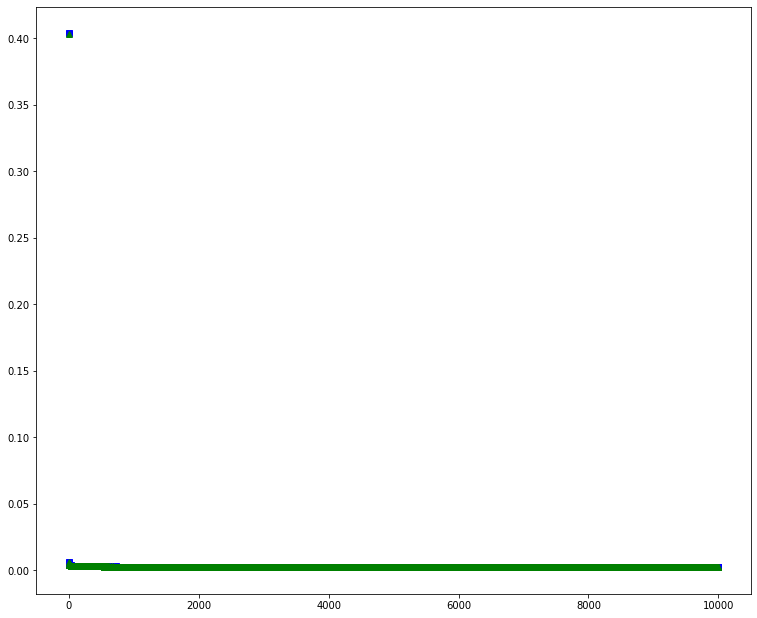

In [17]:
plt.figure(figsize = (12.8, 10.8))
plt.plot(range(epochs), listtrain_loss, "bs", range(epochs), listtest_loss, "g^")

### Train with dropout = 0.2

In [18]:
# Get data
x_np = data[:, :-1]
y_np = data[:, -1:]
print(x_np.shape)
print(y_np.shape)

x_train = x_np[train_indices]
y_train = y_np[train_indices]
x_test = x_np[test_indices]
y_test = y_np[test_indices]

(400, 7)
(400, 1)


In [19]:
# hyperparams
learning_rate = 1e-3
epochs = 10000
dropout = 0.2

# train op
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(total_loss)
sess = tf.Session()

# start train
listtrain_loss = []
listtest_loss = []

sess.run(tf.global_variables_initializer())

train_loss = sess.run(loss, feed_dict = {x: x_train, y:y_train, drop_rate: dropout})
test_loss = sess.run(loss, feed_dict = {x: x_test, y:y_test, drop_rate: dropout})
print("epoch 0, train loss {}, test loss {}".format(train_loss, test_loss))

for i in range(1, epochs+1, 1):
    for minibatch in range(0, num_train_patterns, b):
        sess.run(train_op, feed_dict = {
            x: x_train[minibatch:minibatch+b, :],
            y: y_train[minibatch:minibatch+b, :],
            drop_rate: dropout
        })
    # each epoch, reshuffle the trainset and record
    _indices = np.arange(num_train_patterns)
    np.random.shuffle(_indices)
    x_train = x_train[_indices]
    y_train = y_train[_indices]
    
    train_loss = sess.run(loss, feed_dict = {x: x_train, y:y_train, drop_rate: 0})
    test_loss = sess.run(loss, feed_dict = {x: x_test, y:y_test, drop_rate: 0})
    if (i % 100 == 0):
        print("epoch {}, train loss {}, test loss {}".format(i, train_loss, test_loss))
    listtrain_loss.append(train_loss)
    listtest_loss.append(test_loss)

epoch 0, train loss 2.567216396331787, test loss 2.498887300491333
epoch 100, train loss 0.009551732800900936, test loss 0.009316802024841309
epoch 200, train loss 0.010277172550559044, test loss 0.010168185457587242
epoch 300, train loss 0.00783125963062048, test loss 0.007783896755427122
epoch 400, train loss 0.009826701134443283, test loss 0.00985423568636179
epoch 500, train loss 0.0060454136691987514, test loss 0.0060804313980042934
epoch 600, train loss 0.006003713700920343, test loss 0.006053350865840912
epoch 700, train loss 0.0067449952475726604, test loss 0.0068260845728218555
epoch 800, train loss 0.005594135262072086, test loss 0.005690972786396742
epoch 900, train loss 0.007102084346115589, test loss 0.007248677778989077
epoch 1000, train loss 0.008210742846131325, test loss 0.008376741781830788
epoch 1100, train loss 0.006946654990315437, test loss 0.00709911435842514
epoch 1200, train loss 0.00553267914801836, test loss 0.005654771346598864
epoch 1300, train loss 0.00491

## a) Plot train errors and test errors against epochs

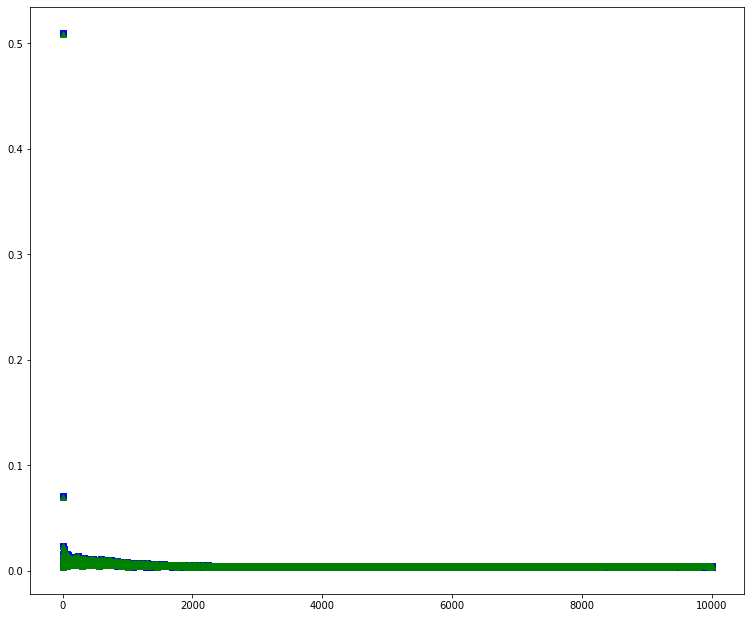

In [20]:
plt.figure(figsize = (12.8, 10.8))
plt.plot(range(epochs), listtrain_loss, "bs", range(epochs), listtest_loss, "g^")

In [23]:
sess.close()